# Anthropogenic heat from human metabolism

This notebook is used to process population data, and ultimately produce the anthropogenic heat flux (AHF) from human metabolism for the Greater Los Angeles (LA) region.

In [1]:
# load packages 
%matplotlib inline
import os
import glob
from pathlib import Path
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
#import requests
import geopandas as gpd
import pyproj
import shapely.geometry
import contextily as ctx
from matplotlib.ticker import FormatStrFormatter
import geofeather
import dask_geopandas as dgpd
import pyogrio
import folium
import numpy as np

In [14]:
# define paths to data
acs_folder = Path('/Users/josephko/USC/Research/Anthropogenic Heat/census/acs')
ctpp_folder = Path('/Users/josephko/USC/Research/Anthropogenic Heat/census/ctpp')
bounds_folder = Path('/Users/josephko/USC/Research/Anthropogenic Heat/boundaries')

In [134]:
# import Census-based ACS data and CTPP data
"""
ACS = american community survey
CTPP = census transportation planning products program
- CTPP data is derived from ACS data
- 5-yr data (2012-2016) is used
- all data below is aggregated to census tract
"""
# import total population (from ACS table B01003)
total_pop_path = acs_folder / 'ACSDT5Y2016.B01003_2022-04-18T013603' / 'ACSDT5Y2016.B01003_data_clean.csv'
total_pop = pd.read_csv(total_pop_path)

# import total workers living in area (from ACS table B08008)
total_workers_living_path = acs_folder / 'ACSDT5Y2016.B08008_2022-04-18T115010' / 'ACSDT5Y2016.B08008_data_clean.csv'
total_workers_living = pd.read_csv(total_workers_living_path)

# import total workers working in area (from CTPP)
total_workers_working_path = ctpp_folder / 'total_workers_lacounty_tract.csv'
total_workers_working = pd.read_csv(total_workers_working_path, dtype = 'string')

# import california census tracts shapefile
tract_bounds_path = bounds_folder / 'ca_2016_census_tracts.zip'
tract_bounds = gpd.read_file(tract_bounds_path)

In [135]:
# convert to appropriate data types

# first get rid of commas and convert to float
total_workers_working['Estimate'] = total_workers_working['Estimate'].str.replace(',', '').astype(float)
total_workers_working['Margin of Error'] = total_workers_working['Margin of Error'].str.replace(',', '').astype(float)

# # then convert to int
# total_workers_working['Estimate'] = total_workers_working['Estimate'].astype('Int64')
# total_workers_working['Margin of Error'] = total_workers_working['Margin of Error'].astype('Int64')

In [136]:
# rename columns of dataframes for further merging 
total_workers_working.rename(columns={'WORKPLACE':'NAME'}, inplace=True)

tract_bounds.rename(columns={'AFFGEOID':'GEO_ID'}, inplace=True)

In [137]:
# merge 'total population' with 'total workers living in area'
cols_to_use = total_workers_living.columns.difference(total_pop.columns).to_list()
cols_to_use.append('GEO_ID')
total_pop_merge_workers_living = total_pop.merge(total_workers_living[cols_to_use], on = 'GEO_ID', how = 'inner')

# continue merging with 'total workers working in area'
total_pop_workers_living_working = total_pop_merge_workers_living.merge(total_workers_working, on='NAME', how='inner')

# final merge with census tract boundaries
final_merged_gdf = tract_bounds.merge(total_pop_workers_living_working, on='GEO_ID', how='right')


In [138]:
"""
Note: The final_merged_gdf has two less records because Census tracts 9901 and 9902 are dropped. 
- these census tracts have populations of zero
- likely census tracts off the coast and therefore not included in the original CA census tracts shapefile
"""
# final_merged_gdf.shape
# final_merged_gdf[final_merged_gdf.geometry==None]
# total_pop[total_pop.GEO_ID == '1400000US06037990200']

'\nNote: The final_merged_gdf has two less records because Census tracts 9901 and 9902 are dropped. \n- these census tracts have populations of zero\n- likely census tracts off the coast and therefore not included in the original CA census tracts shapefile\n'

In [139]:
final_merged_gdf.dtypes

STATEFP              object
COUNTYFP             object
TRACTCE              object
GEO_ID               object
GEOID                object
NAME_x               object
LSAD                 object
ALAND               float64
AWATER              float64
geometry           geometry
NAME_y               object
B01003_001E           int64
B01003_001M           int64
B08008_001E           int64
B08008_001M           int64
B08008_002E           int64
B08008_002M           int64
B08008_003E           int64
B08008_003M           int64
B08008_004E           int64
B08008_004M           int64
B08008_005E           int64
B08008_005M           int64
B08008_006E           int64
B08008_006M           int64
B08008_007E           int64
B08008_007M           int64
B08008_008E           int64
B08008_008M           int64
B08008_009E           int64
B08008_009M           int64
B08008_010E           int64
B08008_010M           int64
B08008_011E           int64
B08008_011M           int64
B08008_012E         

In [140]:
# calculate daytime adjusted population
"""
https://www.census.gov/topics/employment/commuting/guidance/calculations.html
Method 2: Total resident population + Total workers working in area - Total workers living in area
 -> 'B01003_001E' + 'Estimate' - 'B08008_001E'
"""
final_merged_gdf['pop_daytime_adj'] = final_merged_gdf['B01003_001E'] + final_merged_gdf['Estimate'] - final_merged_gdf['B08008_001E']

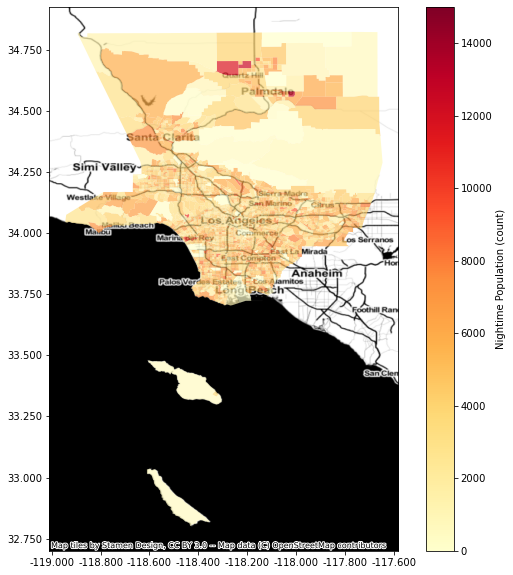

In [143]:
# map night-time (residential) population 
ax = final_merged_gdf.plot(figsize=(10,10), column='B01003_001E', alpha=0.7, 
                           legend=True, cmap='YlOrRd', 
                           vmin = 0, vmax = 15000,
                           legend_kwds={'label':'Nightime Population (count)'})
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs='EPSG:4326')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

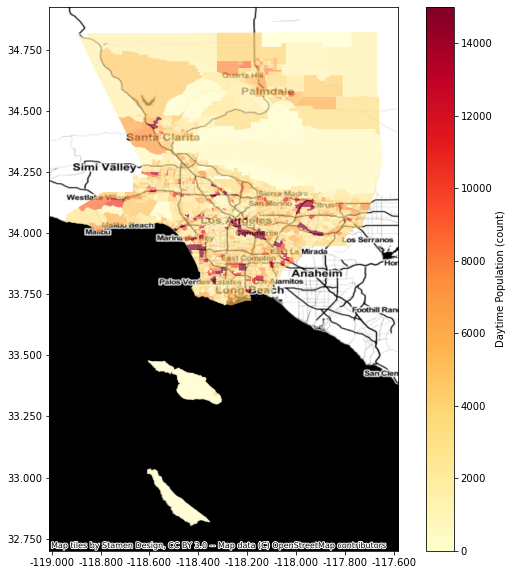

In [144]:
# map daytime-time (commute-adjusted) population 
ax = final_merged_gdf.plot(figsize=(10,10), column='pop_daytime_adj', alpha=0.7, 
                           legend=True, cmap='YlOrRd', 
                           vmin = 0, vmax = 15000,
                           legend_kwds={'label':'Daytime Population (count)'})
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs='EPSG:4326')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

In [ ]:
"""
https://www.census.gov/topics/employment/commuting/guidance/calculations.html
"""